ML PROJECT : FAKE NEWS DETECTION

In [ ]:
# 📚 Import necessary Python libraries for data manipulation and visualization
import pandas as pd                 # For data loading and processing
import numpy as np                  # For numerical operations
import matplotlib.pyplot as plt     # For plotting graphs
import seaborn as sns               # For advanced data visualizations

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulwahabchahal","key":"c5f04898c20cea933a5f43924449ef67"}'}

In [ ]:
import os
import zipfile

# Create a Kaggle directory and move JSON there
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Give permission
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset


Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
with zipfile.ZipFile("fake-and-real-news-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("news_dataset")


In [ ]:
import pandas as pd

# Load both files
fake_df = pd.read_csv('/content/news_dataset/Fake.csv')
real_df = pd.read_csv('/content/news_dataset/True.csv')

# Add labels
fake_df['label'] = 'fake'
real_df['label'] = 'real'

# Combine into one dataset
df = pd.concat([fake_df, real_df], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
df = df[['text', 'label']]  # Or add 'title' if you want

In [ ]:
# 👀 Display the first 5 rows to get a quick look at the dataset
df.head()

In [ ]:
# 📐 Show the shape of the dataset: number of rows and columns
print("Dataset shape:", df.shape)

In [ ]:
# 🏷️ List all column names to understand available data fields
print("Column names:", df.columns)

In [ ]:
# 🔍 Get information about data types and null values
df.info()  # Shows data types, non-null counts, and memory usage

In [ ]:
# ❓ Count missing (null) values in each column
print("Missing values per column:\n", df.isnull().sum())

In [ ]:
# 📊 Show descriptive statistics (mean, std, min, max, etc.)
print("Descriptive Statistics:\n", df.describe(include='all'))

In [ ]:
# 📉 Check the balance between Fake and Real news classes
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])  # Bar chart
plt.title("Distribution of Real vs Fake News")
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [ ]:
# ✍️ Add a new column with the length of each news article
df['text_length'] = df['text'].apply(len)  # Apply len() to every row in 'text'
df

In [ ]:
# 📏 Show statistics about article lengths
print("Text length statistics:\n", df['text_length'].describe())

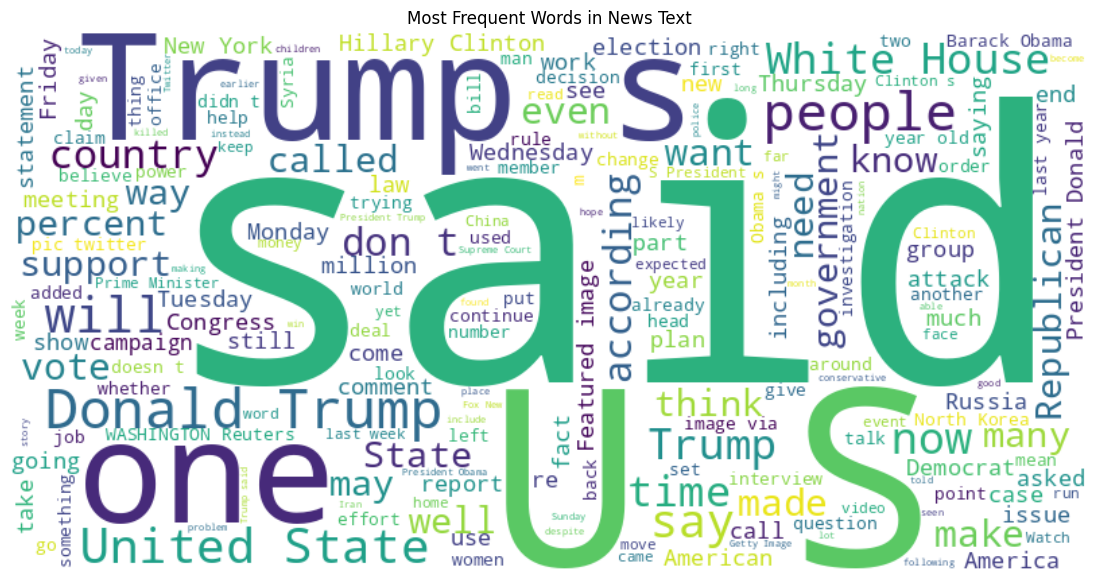

In [ ]:
# ☁️ Generate a word cloud of the most common words in the dataset
from wordcloud import WordCloud     # import wordcloud
from collections import Counter     # For counting word frequency
# Combine all text into one large string
text_corpus = ' '.join(df['text'])
# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')  # Render the image
plt.axis('off')  # Hide axes
plt.title("Most Frequent Words in News Text")
plt.show()

In [ ]:
# 🔁 Check and remove duplicates only where both 'title' and 'text' are the same
duplicate_count = df.duplicated(subset=['text']).sum()  # Count such duplicates
print("Duplicate rows (text):", duplicate_count)

# Drop rows that are exact duplicates in both 'title' and 'text' columns
df = df.drop_duplicates(subset=['text'])

Duplicate rows (text): 6252


In [ ]:
df.shape

(38646, 3)

In [ ]:
# 🏷️ Encode labels (if they are strings like 'FAKE', 'REAL') into binary (0 or 1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])  # Fake → 1, Real → 0 (or vice versa)

/tmp/ipython-input-23-3570082471.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = le.fit_transform(df['label'])  # Fake → 1, Real → 0 (or vice versa)


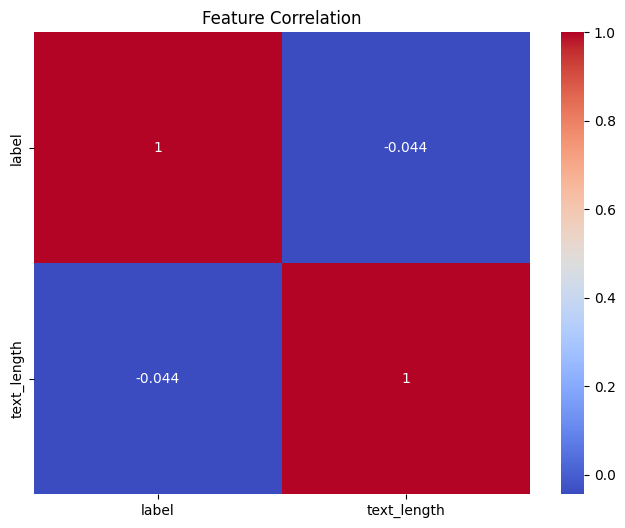

In [ ]:
# 📊 (Optional) Show correlation between numerical features
plt.figure(figsize=(8, 6))
# Select only numerical columns for correlation
numerical_df = df[['label', 'text_length']]
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')  # Heatmap of feature correlations
plt.title("Feature Correlation")
plt.show()

In [ ]:
# 💾 (Optional) Save the cleaned version of the dataset for next steps
df.to_csv('cleaned_fake_news_dataset.csv', index=False)

In [ ]:
df.shape

(38646, 3)

In [ ]:
# 📚 Import required libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 📦 Download NLTK data (only once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Set of English stopwords
stemmer = PorterStemmer()  # Initialize Porter Stemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 🧽 Function to clean, remove stopwords, and stem the text
def preprocess_text(text):
    text = text.lower()                          # Lowercase the text
    text = re.sub(r'\d+', '', text)              # Remove numbers
    text = re.sub(r'\W+', ' ', text)             # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra spaces
    words = text.split()                         # Tokenize
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords and stem
    return ' '.join(words)                       # Reconstruct the cleaned text

# 🧼 Apply preprocessing to the text column
df['text'] = df['text'].apply(preprocess_text)


/tmp/ipython-input-28-3975806674.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(preprocess_text)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.7, min_df=5, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# ⚙️ Train the classifier
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

def evaluate_classification_model(y_true, y_pred, y_prob, labels=('Real', 'Fake')):
    """
    Computes and displays all major evaluation metrics for a binary classification problem.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels
    - y_prob: Predicted probabilities for the positive class (e.g., Fake)
    - labels: Class label names for display (default: Real and Fake)
    """

    # 📊 Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"🔍 Accuracy   : {accuracy:.4f}")
    print(f"🎯 Precision : {precision:.4f}")
    print(f"📥 Recall    : {recall:.4f}")
    print(f"📊 F1-Score  : {f1:.4f}")
    print(f"🏁 AUC Score : {auc:.4f}\n")

    # 🔲 Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # 📈 ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Baseline
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



🔍 Accuracy   : 0.9814
🎯 Precision : 0.9781
📥 Recall    : 0.9882
📊 F1-Score  : 0.9831
🏁 AUC Score : 0.9970



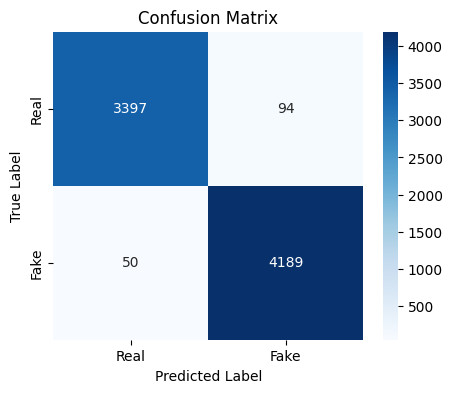

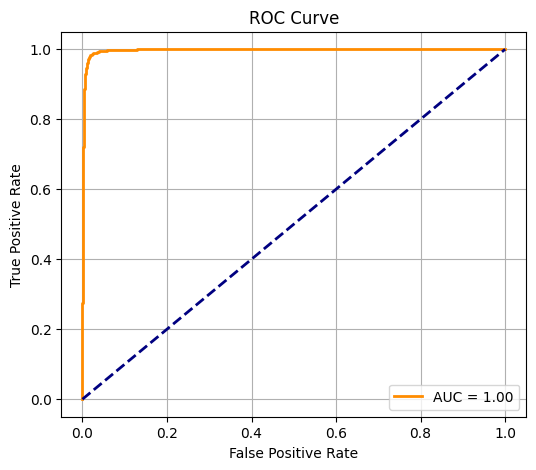

In [ ]:
y_pred = model.predict(X_test_tfidf)                   # Predicted class labels
y_prob = model.predict_proba(X_test_tfidf)[:, 1]       # Probability of class 1 (Fake)

evaluate_classification_model(y_test, y_pred, y_prob)


🔍 Accuracy   : 0.9935
🎯 Precision : 0.9934
📥 Recall    : 0.9948
📊 F1-Score  : 0.9941
🏁 AUC Score : 0.9934



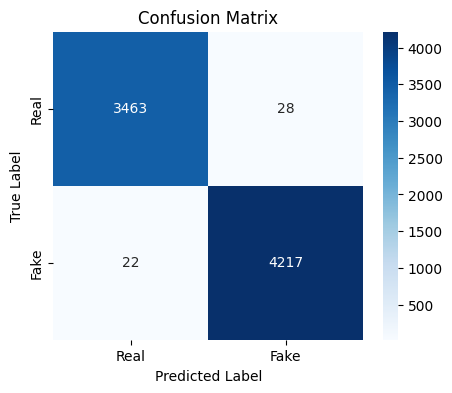

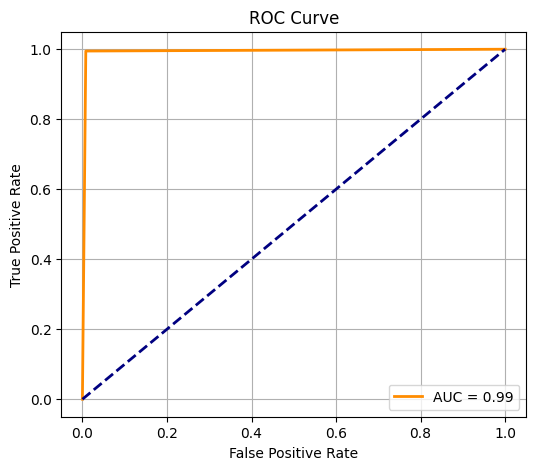

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 🧠 Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# 🏋️ Train the model
dt_model.fit(X_train_tfidf, y_train)

# 🔮 Predict on test data
dt_pred = dt_model.predict(X_test_tfidf)
dt_prob = dt_model.predict_proba(X_test_tfidf)[:, 1]
# 📊 Evaluate
evaluate_classification_model(y_test, dt_pred, dt_prob)


🔍 Accuracy   : 0.9890
🎯 Precision : 0.9857
📥 Recall    : 0.9943
📊 F1-Score  : 0.9900
🏁 AUC Score : 0.9990



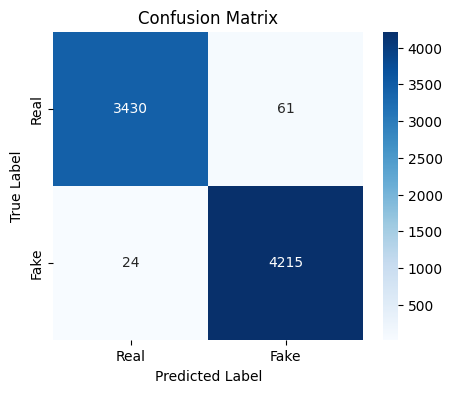

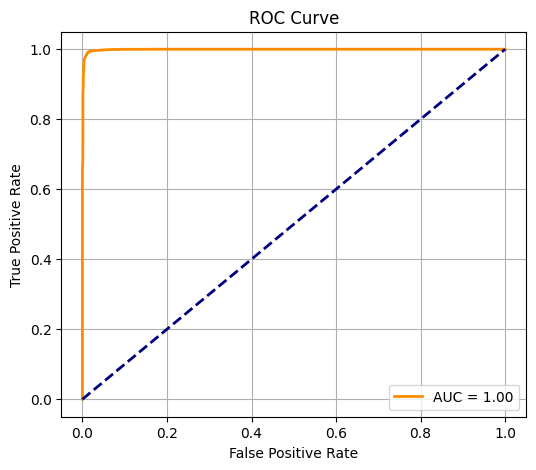

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 🧠 Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 🏋️ Train
rf_model.fit(X_train_tfidf, y_train)

# 🔮 Predict
rf_pred = rf_model.predict(X_test_tfidf)
rf_prob = rf_model.predict_proba(X_test_tfidf)[:, 1]

# 📊 Evaluate
evaluate_classification_model(y_test, rf_pred, rf_prob)


🔍 Accuracy   : 0.8649
🎯 Precision : 0.9021
📥 Recall    : 0.8455
📊 F1-Score  : 0.8729
🏁 AUC Score : 0.9185



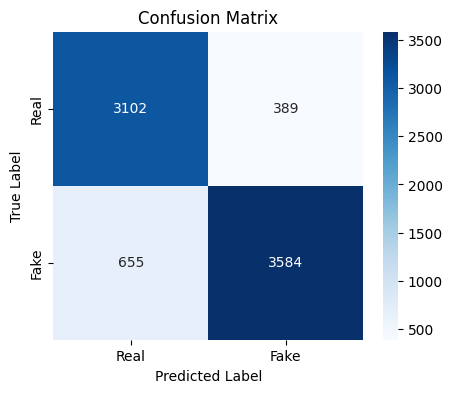

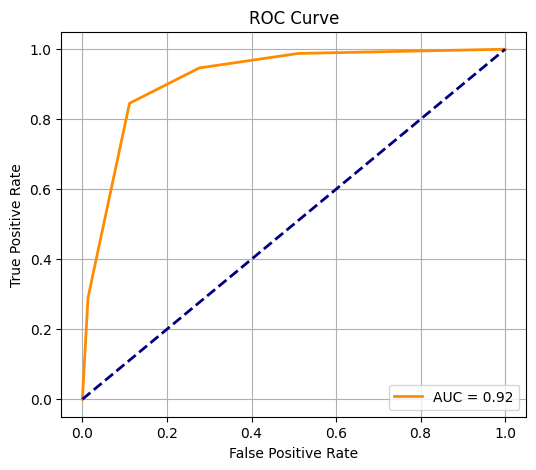

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 🧠 Initialize
knn_model = KNeighborsClassifier(n_neighbors=5)

# 🏋️ Train
knn_model.fit(X_train_tfidf, y_train)

# 🔮 Predict
knn_pred = knn_model.predict(X_test_tfidf)
knn_prob = knn_model.predict_proba(X_test_tfidf)[:, 1]

# 📊 Evaluate
evaluate_classification_model(y_test, knn_pred, knn_prob)


🔍 Accuracy   : 0.9749
🎯 Precision : 0.9735
📥 Recall    : 0.9809
📊 F1-Score  : 0.9772
🏁 AUC Score : 0.9963



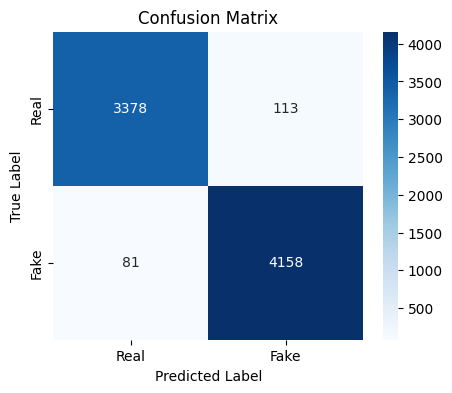

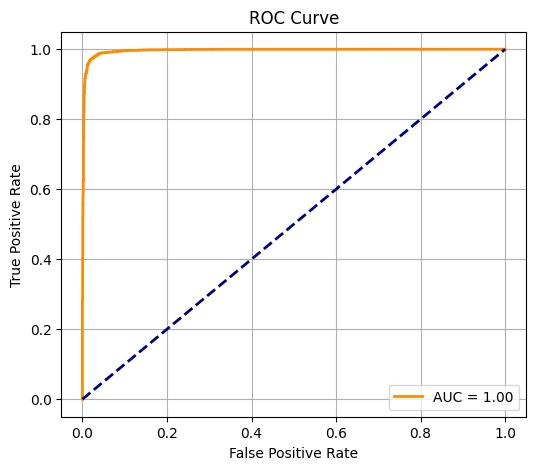

In [47]:
from sklearn.svm import SVC

 #  For experimentation only
X_sample = X_train_tfidf[:5000]
y_sample = y_train[:5000]



# 🧠 Initialize with probability=True for AUC/ROC
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# 🏋️ Train
svm_model.fit(X_sample, y_sample)

# 🔮 Predict
svm_pred = svm_model.predict(X_test_tfidf)
svm_prob = svm_model.predict_proba(X_test_tfidf)[:, 1]

# 📊 Evaluate
evaluate_classification_model(y_test, svm_pred, svm_prob)


🔍 Accuracy   : 0.9268
🎯 Precision : 0.9326
📥 Recall    : 0.9339
📊 F1-Score  : 0.9333
🏁 AUC Score : 0.9761



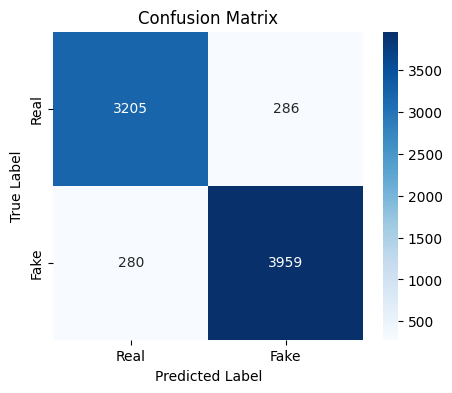

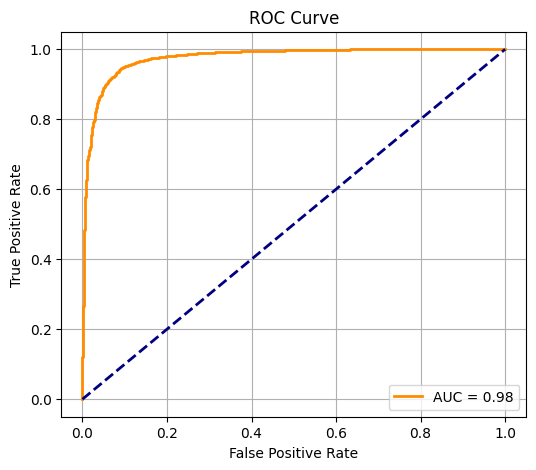

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# 🧠 Initialize
nb_model = MultinomialNB()

# 🏋️ Train
nb_model.fit(X_train_tfidf, y_train)

# 🔮 Predict
nb_pred = nb_model.predict(X_test_tfidf)
nb_prob = nb_model.predict_proba(X_test_tfidf)[:, 1]

# 📊 Evaluate
evaluate_classification_model(y_test, nb_pred, nb_prob)


In [ ]:
pip install tensorflow


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [ ]:
# 🌱 Define input dimension based on TF-IDF output shape
input_dim = X_train_tfidf.shape[1]

# 🧠 Define ANN architecture
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))   # First hidden layer
model.add(Dropout(0.5))                                          # Dropout for regularization
model.add(Dense(64, activation='relu'))                          # Second hidden layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))                        # Output layer (binary classification)

# 🧪 Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🏋️ Train the model
history = model.fit(X_train_tfidf.toarray(), y_train,  # Convert sparse matrix to dense
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9001 - loss: 0.2433 - val_accuracy: 0.9830 - val_loss: 0.0495
Epoch 2/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9947 - loss: 0.0188 - val_accuracy: 0.9846 - val_loss: 0.0445
Epoch 3/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.9985 - loss: 0.0061 - val_accuracy: 0.9853 - val_loss: 0.0509
Epoch 4/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9846 - val_loss: 0.0571
Epoch 5/5
737/773 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9995 - loss: 0.0023

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
🔍 Accuracy   : 0.9820
🎯 Precision : 0.9810
📥 Recall    : 0.9863
📊 F1-Score  : 0.9836
🏁 AUC Score : 0.9978



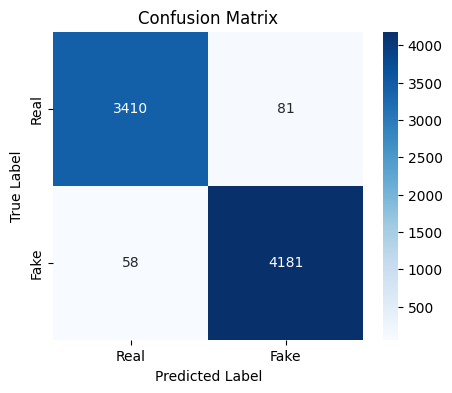

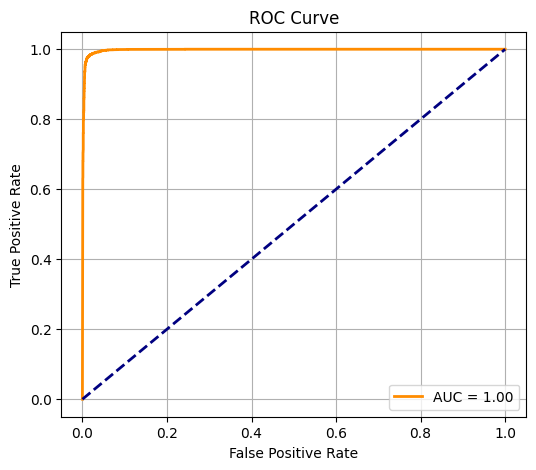

In [ ]:
# 📊 Predict class probabilities
y_prob_ann = model.predict(X_test_tfidf.toarray()).flatten()

# 🔮 Convert probabilities to binary predictions (0 or 1)
y_pred_ann = (y_prob_ann >= 0.5).astype(int)

# 📈 Evaluate
evaluate_classification_model(y_test, y_pred_ann, y_prob_ann)



Model Comparison Summary:
                           Accuracy  Precision  Recall  F1 Score  AUC Score
Logistic Regression          0.9814     0.9781  0.9882    0.9831     0.9970
Decision Tree                0.9935     0.9934  0.9948    0.9941     0.9934
Random Forest                0.9890     0.9857  0.9943    0.9900     0.9990
K-Nearest Neighbors          0.8649     0.9021  0.8455    0.8729     0.9185
Support Vector Machine       0.9749     0.9735  0.9809    0.9772     0.9963
Naive Bayes                  0.9268     0.9326  0.9339    0.9333     0.9761
Artificial Neural Network    0.9820     0.9810  0.9863    0.9836     0.9978


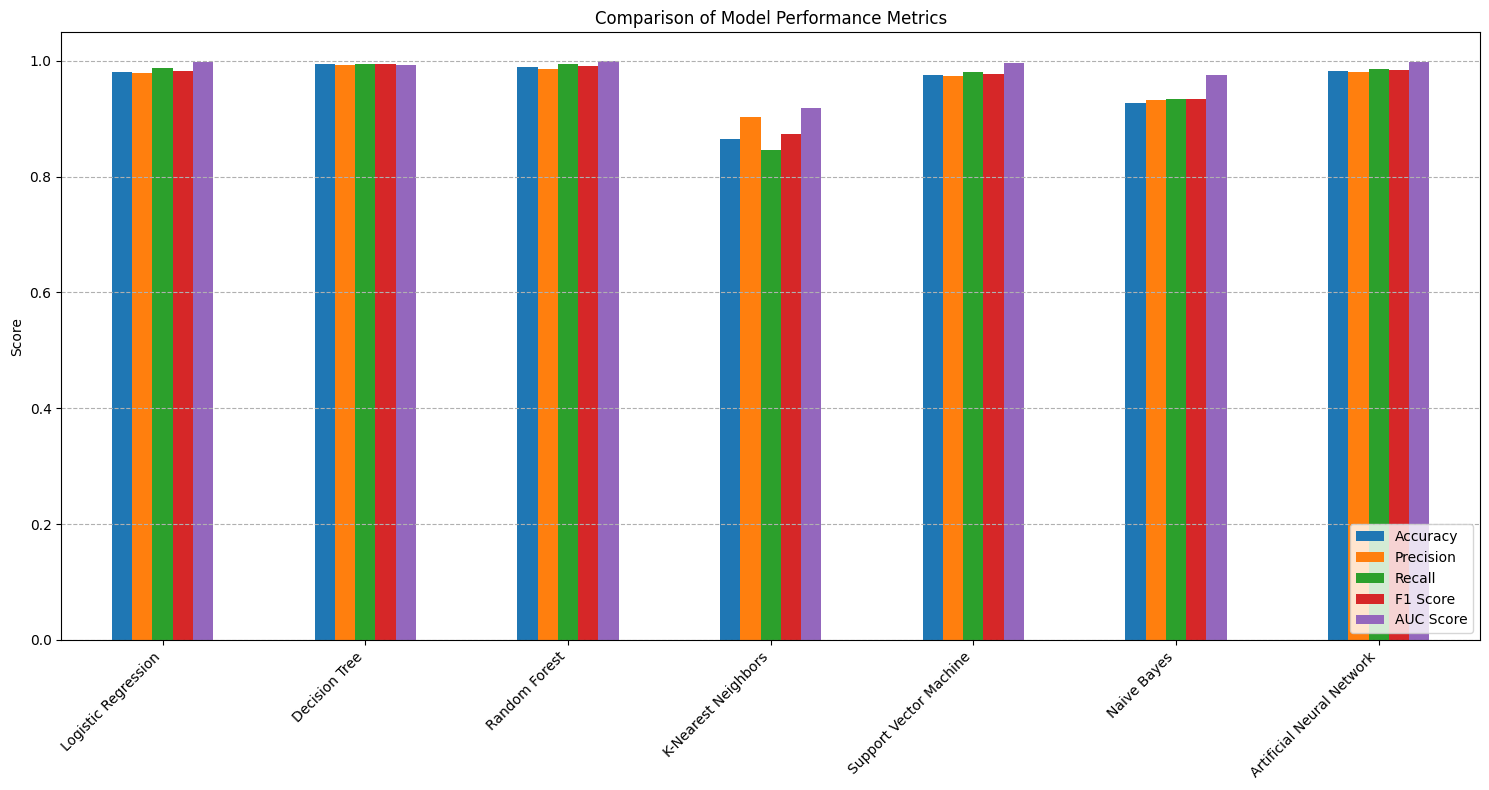

In [48]:
# prompt: comparsion of all model now with their report

# Collect results in a dictionary
results = {
    'Logistic Regression': {'y_pred': y_pred, 'y_prob': y_prob},
    'Decision Tree': {'y_pred': dt_pred, 'y_prob': dt_prob},
    'Random Forest': {'y_pred': rf_pred, 'y_prob': rf_prob},
    'K-Nearest Neighbors': {'y_pred': knn_pred, 'y_prob': knn_prob},
    'Support Vector Machine': {'y_pred': svm_pred, 'y_prob': svm_prob},
    'Naive Bayes': {'y_pred': nb_pred, 'y_prob': nb_prob},
    'Artificial Neural Network': {'y_pred': y_pred_ann, 'y_prob': y_prob_ann},
}

# Store evaluation metrics
evaluation_summary = {}

# Iterate through models and collect metrics
for model_name, preds in results.items():
    accuracy = accuracy_score(y_test, preds['y_pred'])
    precision = precision_score(y_test, preds['y_pred'])
    recall = recall_score(y_test, preds['y_pred'])
    f1 = f1_score(y_test, preds['y_pred'])
    auc = roc_auc_score(y_test, preds['y_prob'])

    evaluation_summary[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }

# Convert summary to a Pandas DataFrame for easy viewing
evaluation_df = pd.DataFrame.from_dict(evaluation_summary, orient='index')

# Print the comparison table
print("\nModel Comparison Summary:")
print(evaluation_df.round(4)) # Round to 4 decimal places for readability

# (Optional) Visualize metrics
evaluation_df.plot(kind='bar', figsize=(15, 8))
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

